In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


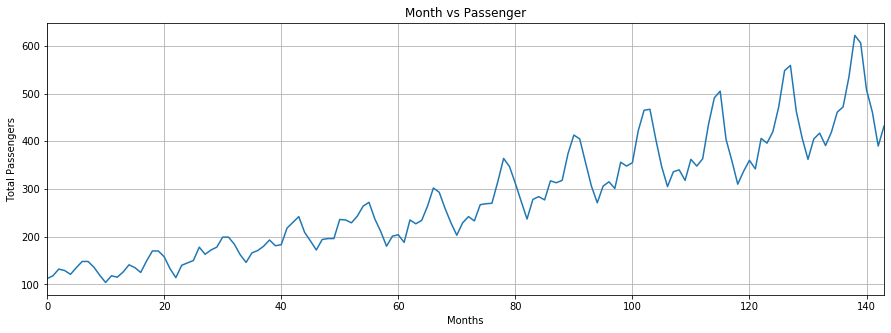

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [4]:
all_data = flight_data['passengers'].values.astype(float)
all_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

Next, we will divide our data set into training and test sets. The LSTM algorithm will be trained on the training set. The model will then be used to make predictions on the test set. The predictions will be compared with the actual values in the test set to evaluate the performance of the trained model.

The first 132 records will be used to train the model and the last 12 records will be used as a test set. The following script divides the data into training and test sets.

In [5]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

132
12


The following code normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively.

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [7]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [8]:
train_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        #self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
        #                    torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00022989
epoch:  26 loss: 0.00769738
epoch:  51 loss: 0.00923593
epoch:  76 loss: 0.00000379
epoch: 101 loss: 0.00242176
epoch: 126 loss: 0.00723998
epoch: 149 loss: 0.0003031624


Now that our model is trained, we can start to make predictions. Since our test set contains the passenger data for the last 12 months and our model is trained to make predictions using a sequence length of 12. We will first filter the last 12 values from the training set:

In [12]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)


[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


You can compare the above values with the last 12 values of the train_data_normalized data list.

Initially the test_inputs item will contain 12 items. Inside a for loop these 12 items will be used to make predictions about the first item from the test set i.e. the item number 133. The predict value will then be appended to the test_inputs list. During the second iteration, again the last 12 items will be used as input and a new prediction will be made which will then be appended to the test_inputs list again. The for loop will execute for 12 times since there are 12 elements in the test set. At the end of the loop the test_inputs list will contain 24 items. The last 12 items will be the predicted values for the test set.

In [18]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())



In [14]:
test_inputs[fut_pred:]

[0.6324216723442078,
 0.7457765340805054,
 0.880242645740509,
 0.991682767868042,
 1.0766551494598389,
 1.1418027877807617,
 1.1951128244400024,
 1.2418287992477417,
 1.2854337692260742,
 1.328979730606079,
 1.3729887008666992,
 1.4180670976638794]

In [15]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[475.37593046]
 [501.1641615 ]
 [531.75520191]
 [557.10782969]
 [576.4390465 ]
 [591.26013422]
 [603.38816756]
 [614.01605183]
 [623.9361825 ]
 [633.84288871]
 [643.85492945]
 [654.11026472]]


[132 133 134 135 136 137 138 139 140 141 142 143]


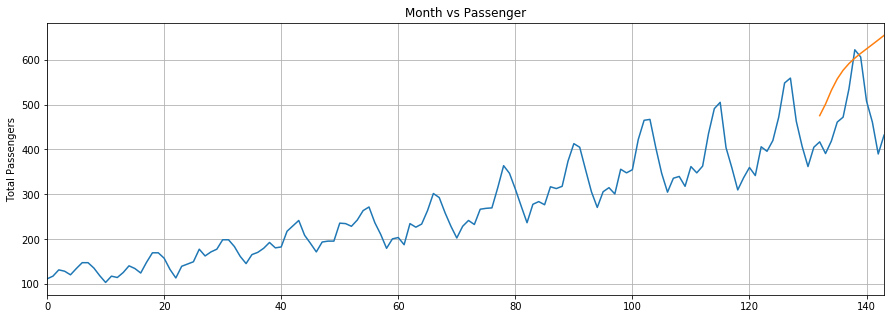

In [16]:
x = np.arange(132, 144, 1)
print(x)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

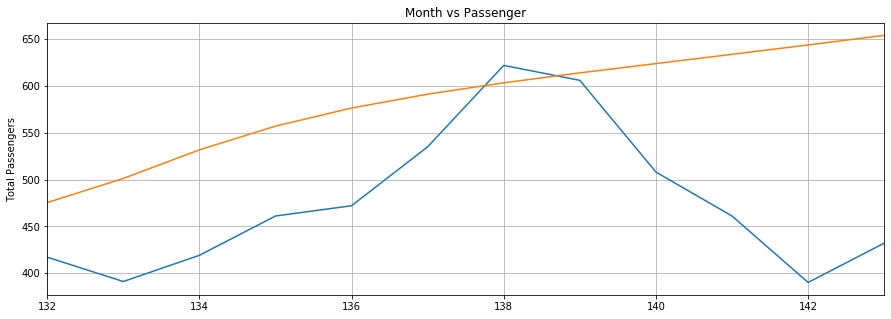

In [17]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()
